In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
# Load data
fear_greed = pd.read_csv('/content/fear_greed_index.csv')
trader_df = pd.read_csv('/content/historical_data.csv')

# datetime parsing
fear_greed['date'] = pd.to_datetime(fear_greed['date'], infer_datetime_format=True, errors='coerce')
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], infer_datetime_format=True, errors='coerce')
trader_df['date'] = trader_df['Timestamp IST'].dt.date

/tmp/ipython-input-3866037282.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fear_greed['date'] = pd.to_datetime(fear_greed['date'], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-3866037282.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], infer_datetime_format=True, errors='coerce')


In [3]:
# Feature Engineering

# Convert to numeric
trader_df['Start Position'] = pd.to_numeric(trader_df['Start Position'], errors='coerce')
trader_df['Execution Price'] = pd.to_numeric(trader_df['Execution Price'], errors='coerce')
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')

# Compute Position Value
trader_df['Position_Value_USD'] = trader_df['Start Position'] * trader_df['Execution Price']

# safer “leverage-like” metric
denom = trader_df['Position_Value_USD'].replace(0, np.nan)
trader_df['Trade_Size_Relative'] = trader_df['Size USD'] / denom

# Win / loss flag
trader_df['is_win'] = trader_df['Closed PnL'] > 0

In [4]:
# Daily Aggregation

# Aggregate daily metrics
daily_stats = trader_df.groupby('date').agg({
    'Closed PnL': ['sum', 'mean'],
    'Trade_Size_Relative': 'mean',
    'Position_Value_USD': 'sum',
    'is_win': 'mean',
    'Size USD': 'sum'
}).reset_index()

# Flatten MultiIndex columns
daily_stats.columns = ['date', 'total_pnl', 'avg_pnl', 'avg_trade_size_rel',
                       'total_position_value', 'win_rate', 'total_volume']

# We have to ensure both are datetime type before merging
daily_stats['date'] = pd.to_datetime(daily_stats['date'])
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

# Merge with sentiment
merged = pd.merge(daily_stats, fear_greed[['date', 'classification']], on='date', how='left')

In [5]:
# Mann-Whitney U Test
fear_group = merged[merged['classification'].str.contains('Fear', na=False)]['total_pnl']
greed_group = merged[merged['classification'].str.contains('Greed', na=False)]['total_pnl']

# Drop NaNs
fear_group = fear_group.dropna()
greed_group = greed_group.dropna()

# Use non-parametric test
if len(fear_group) > 3 and len(greed_group) > 3:
    stat, p = mannwhitneyu(fear_group, greed_group, alternative='two-sided')
    print(f"Mann-Whitney U statistic = {stat:.2f}, p-value = {p:.4f}")
else:
    print("Not enough samples for statistical test.")

Mann-Whitney U statistic = 2251.00, p-value = 0.5873


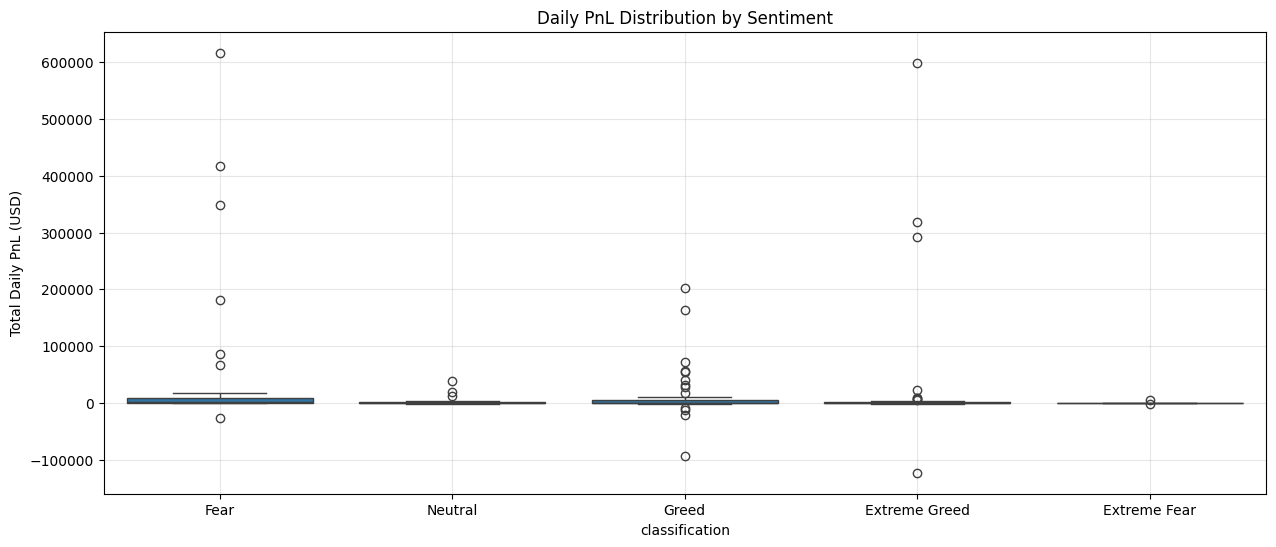

In [6]:
# PnL Distribution
plt.figure(figsize=(15,6))
sns.boxplot(x='classification', y='total_pnl', data=merged)
plt.title('Daily PnL Distribution by Sentiment')
plt.ylabel('Total Daily PnL (USD)')
plt.grid(alpha=0.3)
plt.show()

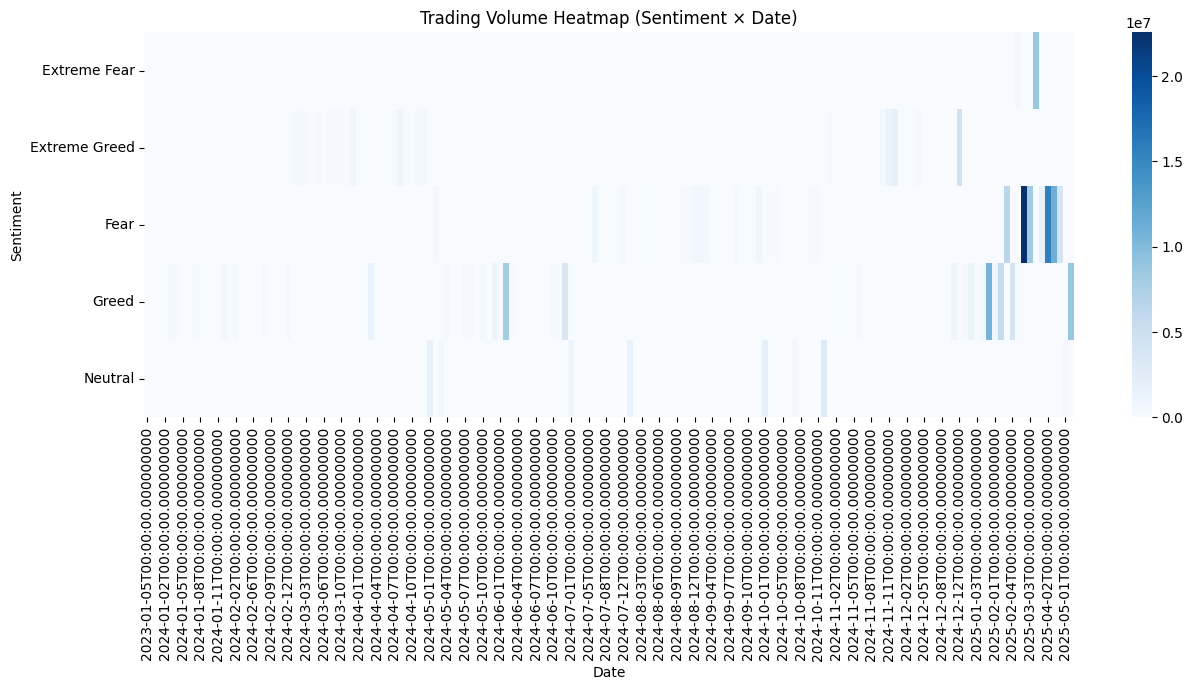

In [7]:
# Volume Heatmap
pivot_vol = merged.pivot_table(index='classification', columns='date',
                               values='total_volume', fill_value=0)
plt.figure(figsize=(15,5))
sns.heatmap(pivot_vol, cmap='Blues')
plt.title('Trading Volume Heatmap (Sentiment × Date)')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

/tmp/ipython-input-1020621006.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='win_rate', data=win_rate, palette='coolwarm')


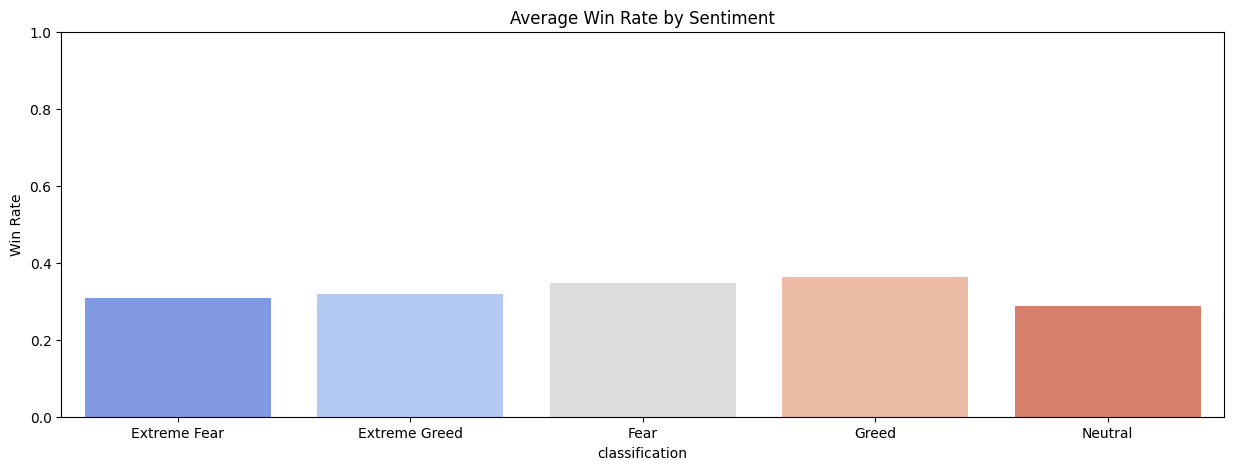

In [8]:
# Win Rate by Sentiment
win_rate = merged.groupby('classification')['win_rate'].mean().reset_index()
plt.figure(figsize=(15,5))
sns.barplot(x='classification', y='win_rate', data=win_rate, palette='coolwarm')
plt.title('Average Win Rate by Sentiment')
plt.ylabel('Win Rate')
plt.ylim(0,1)
plt.show()

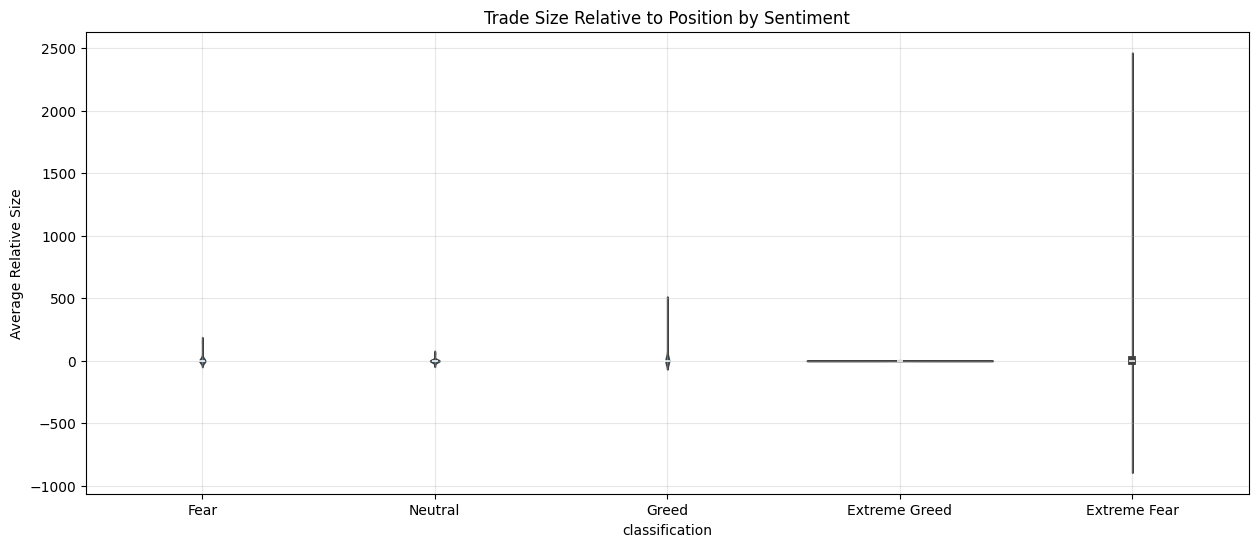

In [9]:
# Filter out extreme values
filtered = merged.copy()
low, high = filtered['avg_trade_size_rel'].quantile([0.01, 0.99])
filtered = filtered[(filtered['avg_trade_size_rel'] >= low) &
                    (filtered['avg_trade_size_rel'] <= high)]

plt.figure(figsize=(15,6))
sns.violinplot(x='classification', y='avg_trade_size_rel', data=filtered)
plt.title('Trade Size Relative to Position by Sentiment')
plt.ylabel('Average Relative Size')
plt.grid(alpha=0.3)
plt.show()


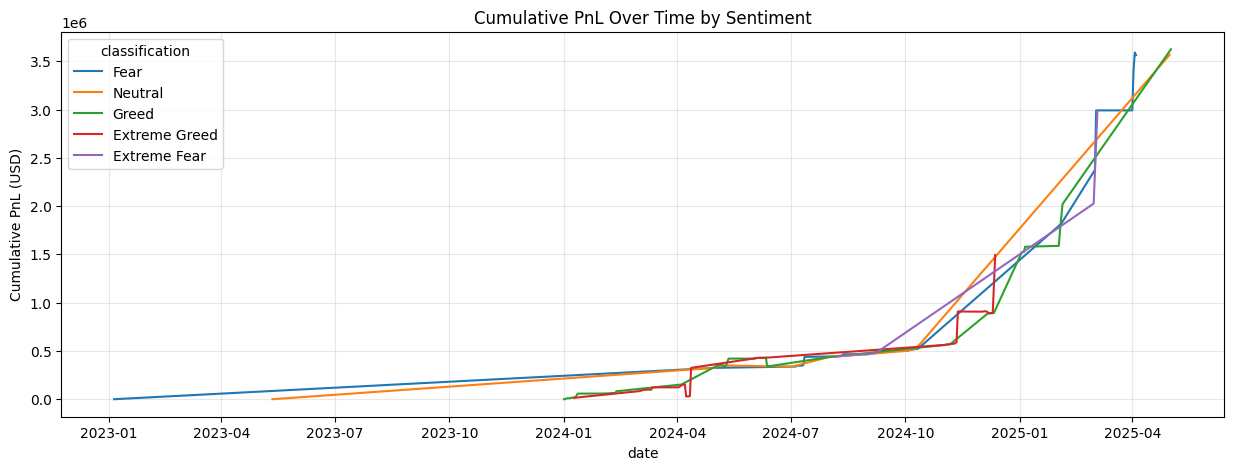

In [10]:
# Cumulative PnL Over Time
merged = merged.sort_values('date')
merged['cum_pnl'] = merged['total_pnl'].cumsum()

plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='cum_pnl', data=merged, hue='classification')
plt.title('Cumulative PnL Over Time by Sentiment')
plt.ylabel('Cumulative PnL (USD)')
plt.grid(alpha=0.3)
plt.show()

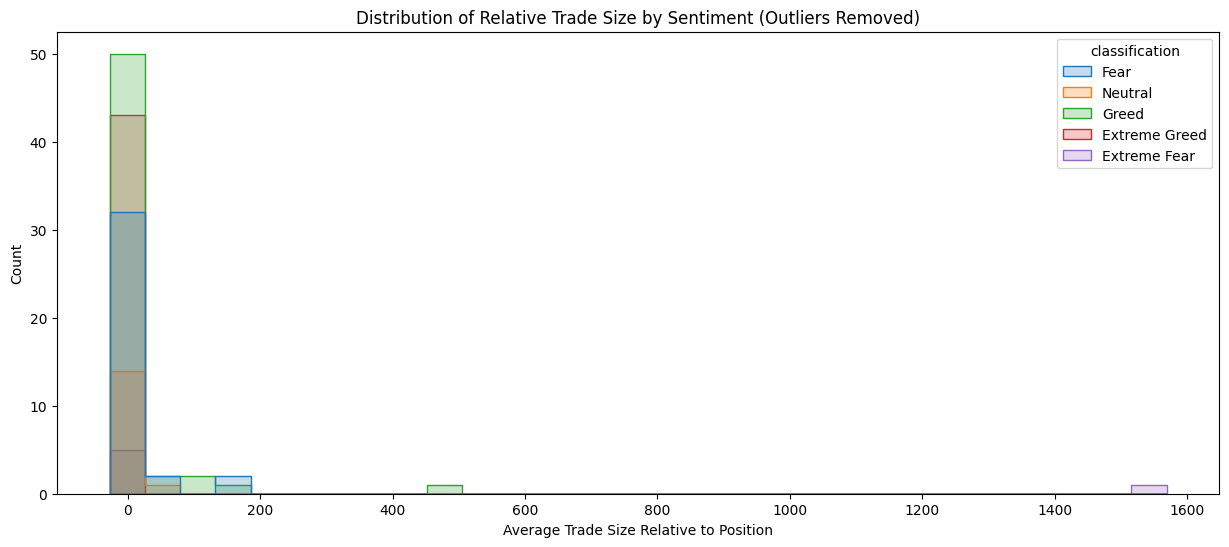

In [11]:
# Leverage (“Relative Size”) Histogram
filtered = merged.copy()
low, high = filtered['avg_trade_size_rel'].quantile([0.01, 0.99])
filtered = filtered[(filtered['avg_trade_size_rel'] >= low) &
                    (filtered['avg_trade_size_rel'] <= high)]

plt.figure(figsize=(15,6))
sns.histplot(data=filtered, x='avg_trade_size_rel', hue='classification',
             element='step', bins=30)
plt.title('Distribution of Relative Trade Size by Sentiment (Outliers Removed)')
plt.xlabel('Average Trade Size Relative to Position')
plt.show()


In [12]:
# Final Insights
summary = merged.groupby('classification')[['total_pnl', 'win_rate',
                                            'avg_trade_size_rel',
                                            'total_volume']].mean().round(2)
print("Summary Statistics by Sentiment:")
display(summary)

Summary Statistics by Sentiment:


,total_pnl,win_rate,avg_trade_size_rel,total_volume
classification,,,,
Extreme Fear,733.32,0.31,262.65,1596706.67
Extreme Greed,26904.50,0.32,0.42,423808.38
Fear,48087.18,0.35,115484.51,2153361.92
Greed,10886.30,0.36,16.24,1018675.28
Neutral,4666.05,0.29,-2.62,746221.95
